<a href="https://colab.research.google.com/github/appliedcode/mthree-c422/blob/mthree-c422-Likhitha/Bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

In [2]:
np.random.seed(42)
n = 1000

genders = ['Male', 'Female']
ethnicities = ['Group_A', 'Group_B', 'Group_C']

# Base demographic distribution
data = pd.DataFrame({
    'Gender': np.random.choice(genders, n, p=[0.6, 0.4]),
    'Ethnicity': np.random.choice(ethnicities, n, p=[0.5, 0.3, 0.2])
})

# Approval bias: Group_A has much higher approval rate
approval_probs = {
    'Group_A': 0.75,
    'Group_B': 0.45,
    'Group_C': 0.40
}

data['Loan_Approved'] = data['Ethnicity'].apply(
    lambda e: np.random.choice([1, 0], p=[approval_probs[e], 1 - approval_probs[e]])
)

print("\n--- Group distribution ---")
print(data['Ethnicity'].value_counts(normalize=True))
print("\n--- Approval rates by ethnicity ---")
print(data.groupby('Ethnicity')['Loan_Approved'].mean())



--- Group distribution ---
Ethnicity
Group_A    0.484
Group_B    0.312
Group_C    0.204
Name: proportion, dtype: float64

--- Approval rates by ethnicity ---
Ethnicity
Group_A    0.760331
Group_B    0.455128
Group_C    0.377451
Name: Loan_Approved, dtype: float64



Chi-square p-value: 1.236e-26 (low p → approval depends on ethnicity)


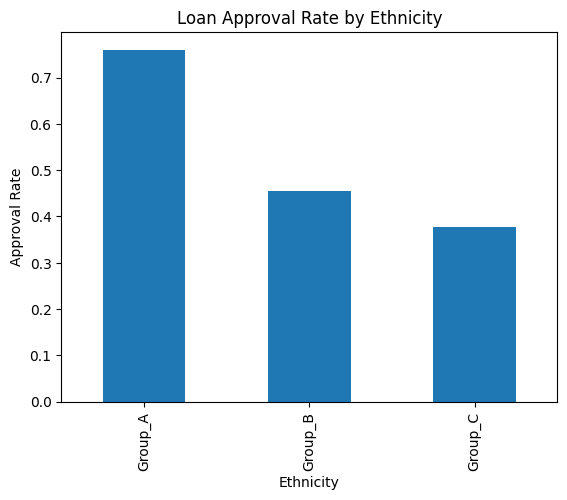

In [3]:
contingency = pd.crosstab(data['Ethnicity'], data['Loan_Approved'])
chi2, p, _, _ = chi2_contingency(contingency)
print(f"\nChi-square p-value: {p:.3e} (low p → approval depends on ethnicity)")

# Visualization
data.groupby('Ethnicity')['Loan_Approved'].mean().plot(
    kind='bar', title='Loan Approval Rate by Ethnicity'
)
plt.ylabel('Approval Rate')
plt.show()

In [4]:
X = pd.get_dummies(data[['Gender', 'Ethnicity']], drop_first=True)
y = data['Loan_Approved']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Group metrics function
def group_metrics(test_df, labels, preds, group_col):
    results = {}
    for g in test_df[group_col].unique():
        idx = test_df[group_col] == g
        tn, fp, fn, tp = confusion_matrix(labels[idx], preds[idx]).ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        acc = (tp + tn) / (tp + tn + fp + fn)
        results[g] = {'Accuracy': acc, 'TPR': tpr, 'FPR': fpr}
    return pd.DataFrame(results)

df_test = X_test.copy()
df_test['Gender'] = data.loc[y_test.index, 'Gender'].values
df_test['Ethnicity'] = data.loc[y_test.index, 'Ethnicity'].values

print("\n--- Metrics by Gender ---")
print(group_metrics(df_test, y_test, y_pred, 'Gender'))

print("\n--- Metrics by Ethnicity ---")
print(group_metrics(df_test, y_test, y_pred, 'Ethnicity'))

# Feature importance
print("\n--- Feature importance ---")
print(pd.Series(model.coef_[0], index=X.columns).sort_values(ascending=False))



--- Metrics by Gender ---
              Male    Female
Accuracy  0.654255  0.705357
TPR       0.627119  0.718750
FPR       0.300000  0.312500

--- Metrics by Ethnicity ---
           Group_C   Group_A   Group_B
Accuracy  0.653846  0.769231  0.521739
TPR       0.000000  1.000000  0.000000
FPR       0.000000  1.000000  0.000000

--- Feature importance ---
Gender_Male         -0.350113
Ethnicity_Group_B   -1.312285
Ethnicity_Group_C   -1.492085
dtype: float64


In [5]:
def demographic_parity(y_true, y_pred, group):
    rates = pd.DataFrame({'y_pred': y_pred, 'group': group}).groupby('group')['y_pred'].mean()
    return rates.max() - rates.min()

def equal_opportunity(y_true, y_pred, group):
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'group': group})
    tprs = []
    for g in df['group'].unique():
        subset = df[df['group'] == g]
        tp = ((subset['y_pred'] == 1) & (subset['y_true'] == 1)).sum()
        fn = ((subset['y_pred'] == 0) & (subset['y_true'] == 1)).sum()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        tprs.append(tpr)
    return max(tprs) - min(tprs)

dp_before = demographic_parity(y_test, y_pred, df_test['Ethnicity'])
eo_before = equal_opportunity(y_test, y_pred, df_test['Ethnicity'])

print(f"\nFairness BEFORE mitigation → DP diff: {dp_before:.3f}, EO diff: {eo_before:.3f}")



Fairness BEFORE mitigation → DP diff: 1.000, EO diff: 1.000


In [8]:
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd

# Example fairness metric functions (replace with yours)
def demographic_parity(y_true, y_pred, sensitive_attr):
    groups = sensitive_attr.unique()
    rates = {g: y_pred[sensitive_attr == g].mean() for g in groups}
    return max(rates.values()) - min(rates.values())

def equal_opportunity(y_true, y_pred, sensitive_attr):
    groups = sensitive_attr.unique()
    tpr = {}
    for g in groups:
        mask = (sensitive_attr == g) & (y_true == 1)
        tpr[g] = (y_pred[mask] == 1).mean()
    return max(tpr.values()) - min(tpr.values())

# Balance the data
df_minority = data[data['Ethnicity'] == 'Group_C']
df_majority = data[data['Ethnicity'] != 'Group_C']
df_minority_up = resample(df_minority, replace=True,
                          n_samples=len(df_majority), random_state=42)
data_balanced = pd.concat([df_majority, df_minority_up]).reset_index(drop=True)

# Prepare features & labels
Xb = pd.get_dummies(data_balanced[['Gender', 'Ethnicity']], drop_first=True)
yb = data_balanced['Loan_Approved']

# Train-test split (indices now match data_balanced)
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    Xb, yb, test_size=0.3, random_state=42, stratify=yb
)

# Train logistic regression
model_balanced = LogisticRegression(solver='liblinear')
model_balanced.fit(Xb_train, yb_train)
yb_pred = model_balanced.predict(Xb_test)

# Match Ethnicity values correctly
dfb_test = Xb_test.copy()
dfb_test['Ethnicity'] = data_balanced.loc[yb_test.index, 'Ethnicity'].values

# Fairness metrics after mitigation
dp_after = demographic_parity(yb_test, yb_pred, dfb_test['Ethnicity'])
eo_after = equal_opportunity(yb_test, yb_pred, dfb_test['Ethnicity'])

print(f"Fairness AFTER mitigation → DP diff: {dp_after:.3f}, EO diff: {eo_after:.3f}")


Fairness AFTER mitigation → DP diff: 1.000, EO diff: 1.000


In [9]:
summary = pd.DataFrame({
    'Metric': ['Demographic Parity Diff', 'Equal Opportunity Diff'],
    'Before': [dp_before, eo_before],
    'After': [dp_after, eo_after]
})
print("\n--- Fairness comparison ---")
print(summary)


--- Fairness comparison ---
                    Metric  Before  After
0  Demographic Parity Diff     1.0    1.0
1   Equal Opportunity Diff     1.0    1.0
